In [61]:
import numpy as np
import pandas as pd
from collections import Counter
import tensorflow as tf

In [62]:
data = pd.read_csv('ferdosi.txt', encoding='utf-8',header = None)

data[0] = data[0].str[:-1]
data[1] = data[1].str[1:]

In [ ]:
text01 = []
for c in data[0]:
    
    text01 = text01 + list(c)
    
text02 = []
for c in data[0]:
    
    text02 = text02 + list(c)

In [ ]:
text = text01 + text02
np.save('text', text)

In [63]:
text = list(np.load('text.npy'))

In [64]:
txt_asci = np.array([ord(c) for c in text]) # Convert to ASCII
frq_asci = []

for c in range(txt_asci.min(), txt_asci.max()+1):
    if (len(np.where(txt_asci == c)[0]) > 0): # Remove infrequent words
        frq_asci.append(c)

In [65]:
chrs = list(chr(x) for x in frq_asci)

In [66]:
chrs = chrs + ['ؤ'] 

In [67]:
numOfchar01 = np.array(list(np.shape(item)[0] for item in list(list(item) for item in data[0])))
numOfchar02 = np.array(list(np.shape(item)[0] for item in list(list(item) for item in data[1])))

In [68]:
num_char = np.max([np.max(numOfchar02),np.max(numOfchar01)])

In [69]:
Dict = dict()
for idx,item in enumerate(chrs):
    Dict[item] = idx+3
Dict['_PAD_'] = 0
Dict['_BOM_'] = 1
Dict['_EOM_'] = 2

In [70]:
# inv dictionary
InvDict = dict()
for item in Dict:
    InvDict[Dict[item]] = item

In [71]:
mes01 = np.array([[0]*(num_char-len(w))+[1]+[Dict[c] for c in w]+[2] for w in data[0]])
mes02 = np.array([[1]+[Dict[c] for c in w]+[2]+[0]*(num_char-len(w)) for w in data[1]])

In [72]:
Train_pre = 0.9

all_beyts    = mes01.shape[0]
permuted_idx = np.random.permutation(np.arange(all_beyts))
num_train    = int(all_beyts*Train_pre)
Train_idx    = permuted_idx[:num_train]
Test_idx     = permuted_idx[num_train:]

Trian_mes01 = mes01[Train_idx,:]
Trian_mes02 = mes02[Train_idx,:]
Test_mes01 = mes01[Test_idx,:]
Test_mes02 = mes02[Test_idx,:]

In [82]:
# hyper-parameters

n_batch = 300
hidden_num = 128
lr_base = 2e-3
lr_decay = 0.999
lr_floor = 1e-5
n_epoch = 100
input_embedding_size = 25
data_in_batch = 200
n_batch = np.int(np.floor(Trian_mes01.shape[0]/data_in_batch))
total_num_char = num_char + 2 # for begin and end

In [74]:
tf.reset_default_graph()

####################################################################
############################# Train ################################
####################################################################

# inputs to the model

Encoder_Input = tf.placeholder(dtype=tf.int32, shape=(data_in_batch, None))
Decoder_Input = tf.placeholder(dtype=tf.int32, shape=(data_in_batch, None))
Decoder_Target = tf.placeholder(dtype=tf.int32, shape=(data_in_batch, None))

embeddings = tf.Variable(tf.random_uniform([len(chrs) + 3, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

EI = tf.nn.embedding_lookup(embeddings, Encoder_Input)
DI = tf.nn.embedding_lookup(embeddings, Decoder_Input)
DT = tf.one_hot(Decoder_Target, depth = int(len(chrs) + 3), on_value=1.0, off_value=0.0, axis=-1)

#########################################################################
############################### Encoder #################################
#########################################################################

# encoder lstm
cell_encoder = tf.contrib.rnn.LSTMCell(num_units=hidden_num, 
                                       use_peepholes=True, 
                                       initializer=tf.contrib.layers.xavier_initializer(),
                                       activation='tanh',
                                       name='cell_encoder')

all_states_ec, final_state_ec = tf.nn.dynamic_rnn(cell=cell_encoder, 
                                                  inputs=EI, 
                                                  initial_state=None,
                                                  time_major=False,dtype=tf.float32)

#########################################################################
############################### Decoder #################################
#########################################################################

# decoder lstm
cell_decoder = tf.contrib.rnn.LSTMCell(num_units=hidden_num, 
                                       use_peepholes=True, 
                                       initializer=tf.contrib.layers.xavier_initializer(),
                                       activation='tanh',
                                       name='cell_decoder')

all_states_dec, final_state_dec = tf.nn.dynamic_rnn(cell=cell_decoder, 
                                                     inputs=DI, 
                                                     initial_state=final_state_ec, 
                                                     time_major=False,
                                                     dtype=tf.float32)
# Outputs

W = tf.get_variable('W', shape=(hidden_num,int(len(chrs) + 3)),initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
b = tf.get_variable('b', shape=(int(len(chrs) + 3),),initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)

Decoder_logit = tf.einsum('ijk,kl', all_states_dec, W)+b

# loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=DT, logits=Decoder_logit, dim=-1))

tf_lr = tf.placeholder(dtype=tf.float32)
train_opt = tf.train.RMSPropOptimizer(learning_rate = tf_lr).minimize(loss)

In [75]:
####################################################################
############################# Test #################################
####################################################################


# placeholders for feeding in test time:
Encoder_Input_test = tf.placeholder(dtype=tf.int32, shape=(data_in_batch, None))
Decoder_Input_test = tf.placeholder(dtype=tf.int32, shape=(data_in_batch, None))


# Initial_dec_h : activations of hidden layer of LSTM cell
# Initial_dec_c : is final output, which can potentially be transfromed with some wrapper
Initial_dec_h = tf.placeholder(dtype=tf.float32, shape=(data_in_batch, hidden_num))
Initial_dec_c = tf.placeholder(dtype=tf.float32, shape=(data_in_batch, hidden_num))


initial_state = tf.nn.rnn_cell.LSTMStateTuple(Initial_dec_c, Initial_dec_h)

EI_test = tf.nn.embedding_lookup(embeddings, Encoder_Input_test)
DI_test = tf.nn.embedding_lookup(embeddings, Decoder_Input_test)

all_states_ec_test, final_state_ec_test = tf.nn.dynamic_rnn(cell=cell_encoder, 
                                             inputs=EI_test, 
                                             initial_state=None, 
                                             time_major=False,
                                             dtype=tf.float32)

all_states_dec_test, final_state_dec_test = tf.nn.dynamic_rnn(cell=cell_decoder, 
                                                             inputs=DI_test, 
                                                             initial_state=initial_state, 
                                                             time_major=False,
                                                             dtype=tf.float32)

logits_test = tf.einsum('ijk,kl', all_states_dec_test, W) + b

In [76]:
train_loss = []
test_loss = []

In [77]:
session = tf.Session()

lr = lr_base

session.run(tf.global_variables_initializer())

for i in range(n_epoch):
    for j in range(n_batch):
        
        # adjusting learning rete 
        if i%10==0:
            lr = lr*lr_decay
            if lr < lr_floor:
                lr = lr_floor
        mes1_minibatch = Trian_mes01[(j)*data_in_batch:min((j+1)*data_in_batch,Trian_mes01.shape[0]),:]
        mes2_minibatch = Trian_mes02[(j)*data_in_batch:min((j+1)*data_in_batch,Trian_mes01.shape[0]),:]
                
        target = mes2_minibatch
        target = np.roll(target,-1,axis=1)
        target[0,-1] = 0
        
        loss_train,_ = session.run([loss,train_opt], feed_dict={Encoder_Input: mes1_minibatch,
                                                               Decoder_Input: mes2_minibatch,
                                                               Decoder_Target: target,
                                                               tf_lr: lr})
                
        test_idx = np.random.randint(0, Test_mes01.shape[0], size = data_in_batch)
        
        target_test = Test_mes02[test_idx,:]
        target_test = np.roll(target,-1,axis=1)
        target_test[0,-1] = 0
        
        loss_test = session.run(loss,feed_dict={Encoder_Input: Test_mes01[test_idx,:],
                                                    Decoder_Input: Test_mes02[test_idx,:],
                                                    Decoder_Target: target_test})
        
        if j%100==0:
            print("Epoch %3i"%i, "====== Loss Train: %.4f" %loss_train,"====== Loss Test: %.4f"%loss_test)
            train_loss = train_loss + [loss_train]
            test_loss = test_loss + [loss_test]


Epoch   0 ====== Loss Train: 3.7704 ====== Loss Test: 3.7576
Epoch   0 ====== Loss Train: 2.4570 ====== Loss Test: 2.5772
Epoch   0 ====== Loss Train: 1.8086 ====== Loss Test: 2.6940
Epoch   1 ====== Loss Train: 1.7456 ====== Loss Test: 2.7656
Epoch   1 ====== Loss Train: 1.6173 ====== Loss Test: 3.0580
Epoch   1 ====== Loss Train: 1.5948 ====== Loss Test: 3.2536
Epoch   2 ====== Loss Train: 1.4898 ====== Loss Test: 3.2906
Epoch   2 ====== Loss Train: 1.4584 ====== Loss Test: 3.3763
Epoch   2 ====== Loss Train: 1.4558 ====== Loss Test: 3.5052
Epoch   3 ====== Loss Train: 1.3642 ====== Loss Test: 3.4750
Epoch   3 ====== Loss Train: 1.3758 ====== Loss Test: 3.6535
Epoch   3 ====== Loss Train: 1.3298 ====== Loss Test: 3.7764
Epoch   4 ====== Loss Train: 1.2740 ====== Loss Test: 3.8273
Epoch   4 ====== Loss Train: 1.3191 ====== Loss Test: 3.8532
Epoch   4 ====== Loss Train: 1.2532 ====== Loss Test: 4.0419
Epoch   5 ====== Loss Train: 1.2320 ====== Loss Test: 3.8808
Epoch   5 ====== Loss Tr

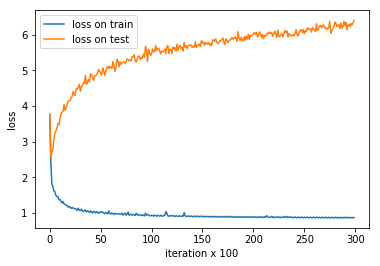

In [78]:
import matplotlib.pyplot as plt

fig1 = plt.figure()  
plt.plot(range(len(train_loss)), train_loss, label='loss on train')
plt.plot(range(len(test_loss)), test_loss, label='loss on test')

plt.xlabel('iteration x 100')
plt.ylabel('loss')
plt.title("")
plt.legend()
plt.show()


In [79]:
Input_mes01 = Trian_mes01[0:data_in_batch,:]

num_of_input = np.shape(Input_mes01)[0]
DecInitState = session.run(final_state_ec_test, feed_dict={Encoder_Input_test: Input_mes01})

# output mesra'
Output = np.array([[Dict['_BOM_']]*num_of_input])

logits, new_state = session.run([logits_test, final_state_dec_test], 
                                    feed_dict={Decoder_Input_test: Output[-1][np.newaxis].T,
                                               Encoder_Input: Input_mes01,
                                               Decoder_Input: Output[-1][np.newaxis].T,
                                               Initial_dec_c: DecInitState[0],
                                               Initial_dec_h: DecInitState[1]})

# in each state we get a char

Output_Char = np.argmax(logits, axis=-1)

Output = np.concatenate((Output,Output_Char.T))
counter = 0 

stop_length = 0

while not all(Output[-1] == Dict['_PAD_'])and stop_length < 50:
    stop_length += 1
    logits, new_state = session.run([logits_test, final_state_dec_test], 
                                        feed_dict={Decoder_Input_test: Output[-1][np.newaxis].T,
                                                   Encoder_Input: Input_mes01,
                                                   Decoder_Input: Output[-1][np.newaxis].T,
                                                   Initial_dec_h: new_state[1],
                                                   Initial_dec_c: new_state[0]})
    Output_Char = np.argmax(logits, axis=-1)
    Output = np.concatenate((Output,Output_Char.T))

Output = Output.T

In [80]:
Output_of_model = [''.join([InvDict[x] for x in Output[idx,:] if not x==0 and not x==1 and not x==2]) for idx in range(50)]
np.save('Output_of_model', Output_of_model)

In [81]:
Output_of_model

['به ایران به دیدار با او زمین',
 'بران سان که بر تخت شاهی بجوش',
 'به ایران برامد ز ایران برو',
 'بران تخت شاهی برامد ز دار',
 'بران تاج و تخت و به روی و سپاه',
 'به پیش اندرون شاه با او بدی',
 'به دیدار با او به دیدار کرد',
 'به پیش سپه را به دل بر گذشت',
 'به دیدار با او به دینار خشک',
 'به دیدار با او به دیدار شاد',
 'به پیش اندرون رای باید شدار',
 'به دیدار با او به ایران نماند',
 'به پیش سپه را به دیدار کرد',
 'به پیش اندرون رای او افتان',
 'بران نامور شهریار جهان',
 'بران نامور شهریار سپی',
 'به دیدار او بر سر از درد و جفت',
 'که از راه بیدار بر ما سرام',
 'به پیش سپه را به دل بر نه اوی',
 'به ایران به ایران نباید نهی',
 'به دیدار بر سر برامد ز خشت',
 'به پیش اندرون رای باید شدار',
 'نبیند به دینار و با او به دست',
 'به پیش سپه را به دل بر گریز',
 'به دیدار او بر سر از داد راه',
 'به دیدار با او به ایران نگیر',
 'سر تخت شاهی به ایران به دشت',
 'بران نامور شهریار جهای',
 'به ایران به دیدار بر سر بود',
 'که ای نامداران و بر پیش گره',
 'بران باره و رای و با او رای',
 'به پیش سپه را

In [83]:
####################################################################
############################# Attention ############################
####################################################################

tf.reset_default_graph()

####################################################################
############################# Train ################################
####################################################################

# inputs to the model

Encoder_Input = tf.placeholder(dtype=tf.int32, shape=(data_in_batch, None))
Decoder_Input = tf.placeholder(dtype=tf.int32, shape=(data_in_batch, None))
Decoder_Target = tf.placeholder(dtype=tf.int32, shape=(data_in_batch, None))

embeddings = tf.Variable(tf.random_uniform([len(chrs) + 3, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

EI = tf.nn.embedding_lookup(embeddings, Encoder_Input)
DI = tf.nn.embedding_lookup(embeddings, Decoder_Input)
DT = tf.one_hot(Decoder_Target, depth = int(len(chrs) + 3), on_value=1.0, off_value=0.0, axis=-1)

#########################################################################
############################### Encoder #################################
#########################################################################

# encoder lstm
cell_encoder = tf.contrib.rnn.LSTMCell(num_units=hidden_num, 
                                       use_peepholes=True, 
                                       initializer=tf.contrib.layers.xavier_initializer(),
                                       activation='tanh',
                                       name='cell_encoder')

all_states_ec, final_state_ec = tf.nn.dynamic_rnn(cell=cell_encoder, 
                                                  inputs=EI, 
                                                  initial_state=None,
                                                  time_major=False,dtype=tf.float32)

#########################################################################
############################### Decoder #################################
#########################################################################

# decoder lstm
cell_decoder = tf.contrib.rnn.LSTMCell(num_units=hidden_num, 
                                       use_peepholes=True, 
                                       initializer=tf.contrib.layers.xavier_initializer(),
                                       activation='tanh',
                                       name='cell_decoder')
# add attention to decoder
BahdanauAttention = tf.contrib.seq2seq.BahdanauAttention(num_units = total_num_char, memory = all_states_ec,
                                                         name = 'BahdanauAttention')
AttentionWrapper = tf.contrib.seq2seq.AttentionWrapper(cell=cell_decoder, attention_mechanism = BahdanauAttention, 
                                                       name='AttentionWrapper')

initial_state = AttentionWrapper.zero_state(data_in_batch, tf.float32).clone(cell_state = final_state_ec)

all_states_dec, final_state_dec = tf.nn.dynamic_rnn(cell=AttentionWrapper, 
                                                     inputs=DI, 
                                                     initial_state=initial_state, 
                                                     time_major=False,
                                                     dtype=tf.float32)
# Outputs

W = tf.get_variable('W', shape=(hidden_num,int(len(chrs) + 3)),initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
b = tf.get_variable('b', shape=(int(len(chrs) + 3),),initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)

Decoder_logit = tf.einsum('ijk,kl', all_states_dec, W)+b

# loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=DT, logits=Decoder_logit, dim=-1))

tf_lr = tf.placeholder(dtype=tf.float32)
train_opt = tf.train.RMSPropOptimizer(learning_rate = tf_lr).minimize(loss)

In [84]:
####################################################################
############################# Test #################################
####################################################################

# placeholders for feeding in test time:
Encoder_Input_test = tf.placeholder(dtype=tf.int32, shape=(data_in_batch, None))
Decoder_Input_test = tf.placeholder(dtype=tf.int32, shape=(data_in_batch, None))

# Initial_dec_h : activations of hidden layer of LSTM cell
# Initial_dec_c : is final output, which can potentially be transfromed with some wrapper
Initial_dec_h = tf.placeholder(dtype=tf.float32, shape=(data_in_batch, hidden_num))
Initial_dec_c = tf.placeholder(dtype=tf.float32, shape=(data_in_batch, hidden_num))

initial_state = tf.nn.rnn_cell.LSTMStateTuple(Initial_dec_c, Initial_dec_h)

EI_test = tf.nn.embedding_lookup(embeddings, Encoder_Input_test)
DI_test = tf.nn.embedding_lookup(embeddings, Decoder_Input_test)

all_states_ec_test, final_state_ec_test = tf.nn.dynamic_rnn(cell=cell_encoder, 
                                             inputs=EI_test, 
                                             initial_state=None, 
                                             time_major=False,
                                             dtype=tf.float32)

Initial_state = AttentionWrapper.zero_state(data_in_batch, tf.float32).clone(cell_state = initial_state)


all_states_dec_test, final_state_dec_test = tf.nn.dynamic_rnn(cell=AttentionWrapper, 
                                                             inputs=DI_test, 
                                                             initial_state=Initial_state, 
                                                             time_major=False,
                                                             dtype=tf.float32)

logits_test = tf.einsum('ijk,kl', all_states_dec_test, W) + b

In [85]:
train_loss = []
test_loss = []

In [86]:
session = tf.Session()

lr = lr_base

session.run(tf.global_variables_initializer())

for i in range(n_epoch):
    for j in range(n_batch):
        
        # adjusting learning rete 
        if i%10==0:
            lr = lr*lr_decay
            if lr < lr_floor:
                lr = lr_floor
        mes1_minibatch = Trian_mes01[(j)*data_in_batch:min((j+1)*data_in_batch,Trian_mes01.shape[0]),:]
        mes2_minibatch = Trian_mes02[(j)*data_in_batch:min((j+1)*data_in_batch,Trian_mes01.shape[0]),:]
                
        target = mes2_minibatch
        target = np.roll(target,-1,axis=1)
        target[0,-1] = 0
        
        loss_train,_ = session.run([loss,train_opt], feed_dict={Encoder_Input: mes1_minibatch,
                                                               Decoder_Input: mes2_minibatch,
                                                               Decoder_Target: target,
                                                               tf_lr: lr})
                
        test_idx = np.random.randint(0, Test_mes01.shape[0], size = data_in_batch)
        
        target_test = Test_mes02[test_idx,:]
        target_test = np.roll(target,-1,axis=1)
        target_test[0,-1] = 0
        
        loss_test = session.run(loss,feed_dict={Encoder_Input: Test_mes01[test_idx,:],
                                                    Decoder_Input: Test_mes02[test_idx,:],
                                                    Decoder_Target: target_test})
        
        if j%100==0:
            print("Epoch %3i"%i, "====== Loss Train: %.4f" %loss_train,"====== Loss Test: %.4f"%loss_test)
            train_loss = train_loss + [loss_train]
            test_loss = test_loss + [loss_test]


Epoch   0 ====== Loss Train: 3.6681 ====== Loss Test: 3.6682
Epoch   0 ====== Loss Train: 2.7769 ====== Loss Test: 2.7727
Epoch   0 ====== Loss Train: 2.1845 ====== Loss Test: 2.5462
Epoch   1 ====== Loss Train: 2.0470 ====== Loss Test: 2.7782
Epoch   1 ====== Loss Train: 1.8412 ====== Loss Test: 3.1054
Epoch   1 ====== Loss Train: 1.7965 ====== Loss Test: 3.4333
Epoch   2 ====== Loss Train: 1.7435 ====== Loss Test: 3.4745
Epoch   2 ====== Loss Train: 1.7200 ====== Loss Test: 3.5588
Epoch   2 ====== Loss Train: 1.6645 ====== Loss Test: 3.7425
Epoch   3 ====== Loss Train: 1.6136 ====== Loss Test: 3.4392
Epoch   3 ====== Loss Train: 1.6450 ====== Loss Test: 3.7282
Epoch   3 ====== Loss Train: 1.6717 ====== Loss Test: 3.9540
Epoch   4 ====== Loss Train: 1.5448 ====== Loss Test: 3.7889
Epoch   4 ====== Loss Train: 1.5193 ====== Loss Test: 3.8673
Epoch   4 ====== Loss Train: 1.4901 ====== Loss Test: 4.2002
Epoch   5 ====== Loss Train: 1.4558 ====== Loss Test: 4.0348
Epoch   5 ====== Loss Tr

In [87]:
Input_mes01 = Trian_mes01[0:data_in_batch,:]

num_of_input = np.shape(Input_mes01)[0]
DecInitState = session.run(final_state_ec_test, feed_dict={Encoder_Input_test: Input_mes01})

# output mesra'
Output_At = np.array([[Dict['_BOM_']]*num_of_input])

logits, new_state = session.run([logits_test, final_state_dec_test], 
                                    feed_dict={Decoder_Input_test: Output_At[-1][np.newaxis].T,
                                               Encoder_Input: Input_mes01,
                                               Decoder_Input: Output_At[-1][np.newaxis].T,
                                               Initial_dec_c: DecInitState[0],
                                               Initial_dec_h: DecInitState[1]})

# in each state we get a char

Output_Char = np.argmax(logits, axis=-1)

Output_At = np.concatenate((Output_At,Output_Char.T))
counter = 0 

stop_length = 0

while not all(Output[-1] == Dict['_PAD_'])and stop_length < 50:
    stop_length += 1
    logits, new_state = session.run([logits_test, final_state_dec_test], 
                                        feed_dict={Decoder_Input_test: Output_At[-1][np.newaxis].T,
                                                   Encoder_Input: Input_mes01,
                                                   Decoder_Input: Output_At[-1][np.newaxis].T,
                                                   Initial_dec_h: new_state[0][1],
                                                   Initial_dec_c: new_state[0][0]})
    Output_Char = np.argmax(logits, axis=-1)
    Output_At = np.concatenate((Output_At,Output_Char.T))

Output_At = Output_At.T

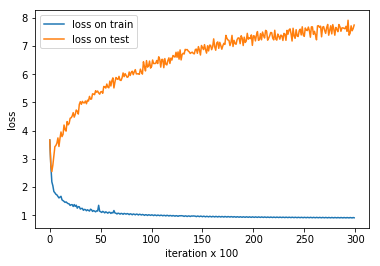

In [88]:
import matplotlib.pyplot as plt

fig1 = plt.figure()  
plt.plot(range(len(train_loss)), train_loss, label='loss on train')
plt.plot(range(len(test_loss)), test_loss, label='loss on test')

plt.xlabel('iteration x 100')
plt.ylabel('loss')
plt.title("")
plt.legend()
plt.show()

In [89]:
Output_At_of_model = [''.join([InvDict[x] for x in Output[idx,:] if not x==0 and not x==1 and not x==2]) for idx in range(50)]
np.save('Output_At_of_model', Output_At_of_model)

In [90]:
Output_At_of_model

['به ایران به دیدار با او زمین',
 'بران سان که بر تخت شاهی بجوش',
 'به ایران برامد ز ایران برو',
 'بران تخت شاهی برامد ز دار',
 'بران تاج و تخت و به روی و سپاه',
 'به پیش اندرون شاه با او بدی',
 'به دیدار با او به دیدار کرد',
 'به پیش سپه را به دل بر گذشت',
 'به دیدار با او به دینار خشک',
 'به دیدار با او به دیدار شاد',
 'به پیش اندرون رای باید شدار',
 'به دیدار با او به ایران نماند',
 'به پیش سپه را به دیدار کرد',
 'به پیش اندرون رای او افتان',
 'بران نامور شهریار جهان',
 'بران نامور شهریار سپی',
 'به دیدار او بر سر از درد و جفت',
 'که از راه بیدار بر ما سرام',
 'به پیش سپه را به دل بر نه اوی',
 'به ایران به ایران نباید نهی',
 'به دیدار بر سر برامد ز خشت',
 'به پیش اندرون رای باید شدار',
 'نبیند به دینار و با او به دست',
 'به پیش سپه را به دل بر گریز',
 'به دیدار او بر سر از داد راه',
 'به دیدار با او به ایران نگیر',
 'سر تخت شاهی به ایران به دشت',
 'بران نامور شهریار جهای',
 'به ایران به دیدار بر سر بود',
 'که ای نامداران و بر پیش گره',
 'بران باره و رای و با او رای',
 'به پیش سپه را